In [6]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
import soundfile as sf  # maybe unneeded if all loading performed with librosa!
import librosa
import librosa.display
import os
from torch.utils.data import DataLoader, Dataset, random_split, Subset

used to clean up es files<br>
ls /media/andres/2D2DA2454B8413B5/test/test/ | grep -o '.....$' | uniq   # exploring file types<br>
media/andres/2D2DA2454B8413B5/test/test/ | grep -o '^es.*'<br>
https://gist.github.com/mthrok/01f89d9bc27a7fe618bf5e8ef71b44ba<br>
librosa vs torchaudio spectograms<br>
worth using sox to check sampling rate https://stackoverflow.com/questions/4497419/how-do-i-get-an-audio-file-sample-rate-using-sox

In [7]:
base_path = "/media/andres/2D2DA2454B8413B5/"
train_dir = base_path + "train/train/"
test_dir = base_path + "test/test/"

defining class

In [13]:
class SpeechDataset(Dataset):
    def __init__(self, flac_dir, load_method):
        self.audio_path_list = sorted(self.find_files(flac_dir))  # do we need them to be sorted?
        methods = {"librosa": self.flac2melspec, "soundfile": self.sf_loader, "torchaudio": self.flac_to_spectro}
        self.chosen_method = methods[load_method]
        
        
    def __len__(self):
        return len(self.audio_path_list)
    def __getitem__(self, index):
        audio_file = self.audio_path_list[index]  
        return self.chosen_method(audio_file)
    def find_files(self, directory, pattern=".flac"):
        """
        Recursive search method to find files. Credit to Paul Magron and Andrea de Marco
        for OG method
        """
        return  [f.path for f in os.scandir(test_dir) if f.path.endswith(pattern)]  # ends with does not like regex
    
    def flac_to_spectro(self, file_path):
        waveform, sample_rate = torchaudio.load(file_path, normalize=True)
        transform = T.MelSpectrogram(sample_rate)        
        return transform(waveform), sample_rate
        
    def sf_loader(self, file_path):
        with open(file_path, "rb") as f:
            data, samplerate = sf.read(f)
        return data, samplerate
    def flac2melspec(self, file_path, n_mels=64, melspec_size=512):
        """
        the librosa method we are using atm, try n_mels == 128
        """
        sig, fs =  librosa.load(file_path, sr=None)
        sig /= np.max(np.abs(sig), axis=0)
        n_fft = melspec_size
        hop_length = int(n_fft/2)

        # padding signal if less than a second
        if len(sig) < fs:
            padded_array = np.zeros(fs)
            padded_array[:np.shape(sig)[0]] = sig
            sig = padded_array            
            
        melspec = librosa.feature.melspectrogram(y=sig, sr=fs,
                                                 center=True, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)
        
        # plotting should be here. can be improved/refactored
        self.plotmelspec(melspec, fs, hop_length, show=True)
        #
        
        melspec = librosa.power_to_db(melspec, ref=1.0)
        print("new plot_1")
        self.plotmelspec(melspec, fs, hop_length, show=True)
        melspec /= 80.0  # highest db...
        print("new plot_2")
        self.plotmelspec(melspec, fs, hop_length, show=True)      
        melspec = self.checkmelspec(melspec, fs)
        print("new plot_3")
        self.plotmelspec(melspec, fs, hop_length, show=True)
        return melspec, fs
    
    def checkmelspec(self, melspec, fs):
        """
        this method works with librosa
        """
        #TODO: check melspec?
        if melspec.shape[1] < 64:  # n_mels
            shape = np.shape(melspec)
            padded_array = np.zeros((shape[0], 64)) - 1
            paddeed_array[0:shape[0], :shape[1]] = melspec
            melspec = padded_array            
        # should we save it? check speech gan assignment script
        return melspec
    
    def plotmelspec(self, melspec, fs, hop_length, show=False):
        plt.figure(figsize=(8, 6))
        plt.xlabel("Time")
        plt.ylabel("Mel-Frequency")
        librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),  # ref_max == 1.0
                                 y_axis="mel", fmax=fs/2, sr=fs,
                                 hop_length=hop_length, x_axis="time")
        plt.colorbar(format="%+2.0f db")
        plt.title("Mel Spectogram")
        plt.tight_layout()
        if show:
            plt.show()

example, tst data has 540 files

In [14]:
test_data = SpeechDataset(test_dir, "librosa")
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)
train_data = SpeechDataset(train_dir, "librosa")
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)

ODO  finish up the splits

In [15]:
train_data = Subset(train_data, torch.arange(240)) # 80% 
test_data = Subset(test_data, torch.arange(60))  # 20%

In [16]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

lest' test visualizations

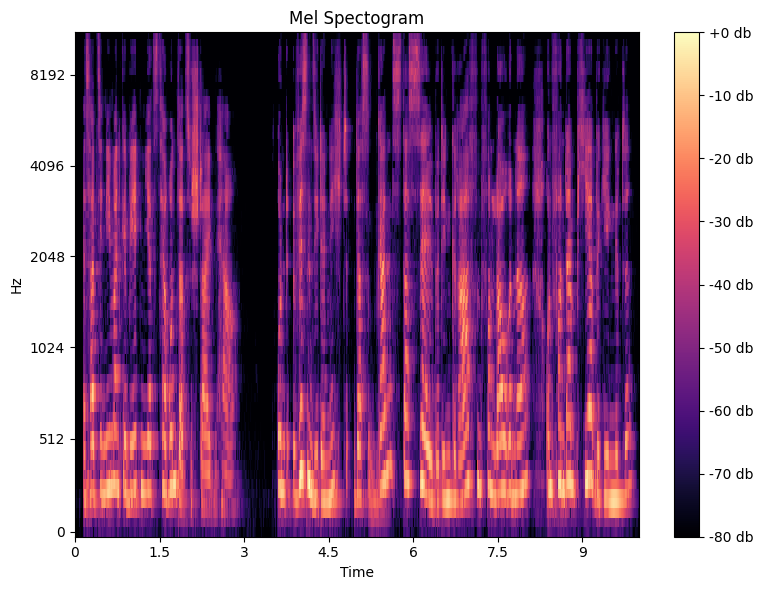

new plot_1


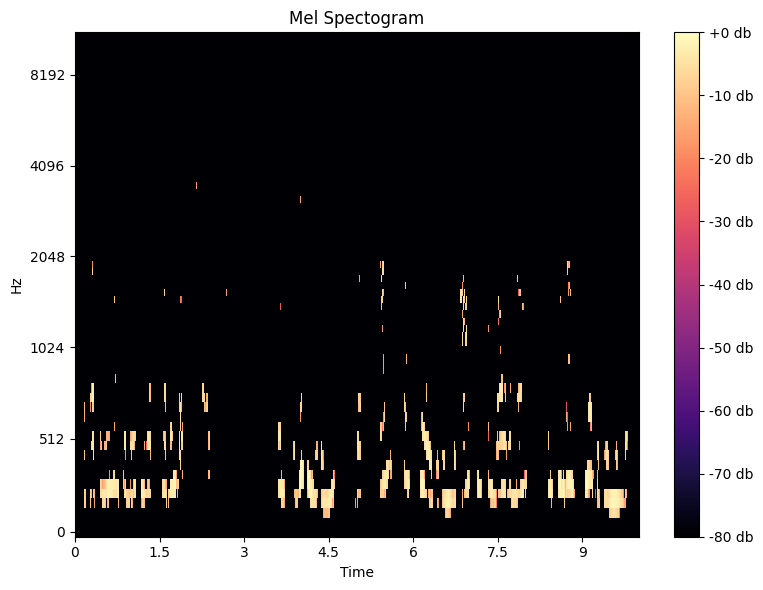

new plot_2


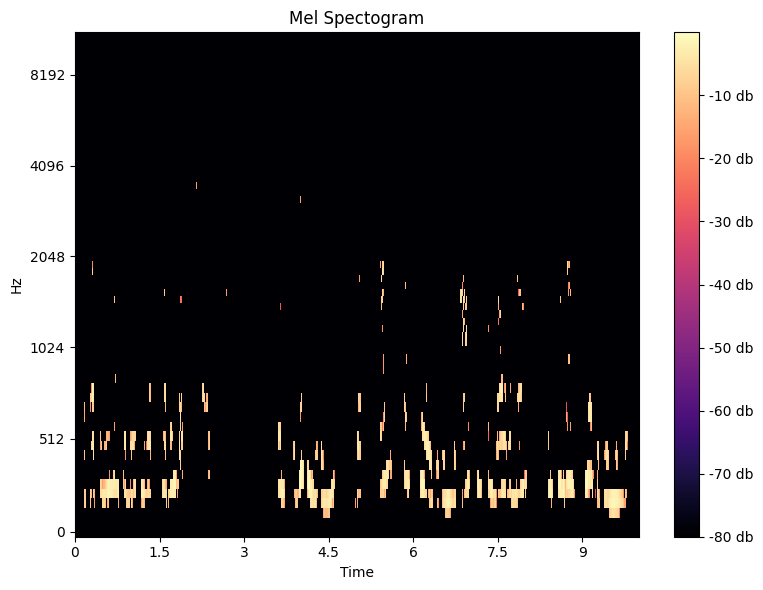

new plot_3


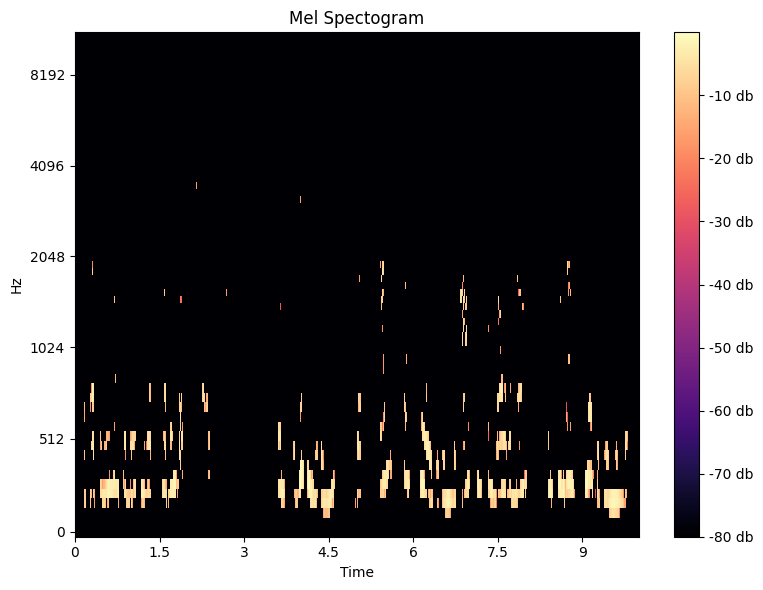

[tensor([[[-0.7312, -0.7312, -0.7312,  ..., -0.6774, -0.6065, -0.7222],
         [-0.7312, -0.7312, -0.7312,  ..., -0.5996, -0.6182, -0.7112],
         [-0.7040, -0.6533, -0.6785,  ..., -0.5297, -0.5647, -0.6409],
         ...,
         [-0.7312, -0.7312, -0.7312,  ..., -0.7312, -0.7312, -0.7312],
         [-0.7312, -0.7312, -0.7312,  ..., -0.7312, -0.7312, -0.7312],
         [-0.7312, -0.7312, -0.7312,  ..., -0.7312, -0.7312, -0.7312]]]), tensor([22050])]


In [17]:
melspec_test = next(iter(test_dataloader))
print(melspec_test)